In [16]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statistics
from get_bounds import *
from plotting_utility import *

### Grid Points Load (output from scoring.ipynb)
Grid Points are now scored in `scoring.ipynb`.

In [17]:
YYZ_GridPoints = pd.read_csv('../res/grid_points/yyz_grid_points.csv', sep = ',')
PT_DENSITY = len(YYZ_GridPoints["lat"].unique())

### Clustered Grid Points Load (output from clustering.ipynb)
Clustered Grid Points (a subset of Grid Points) are now scored in `clustering.ipynb`.

In [18]:
YYZ_Clustered_GridPoints = pd.read_csv('../res/grid_points/yyz_clustered_grid_points.csv', sep = ',')
NUM_CLUSTERS = len(YYZ_Clustered_GridPoints["cluster"].unique())

### Parameters

In [19]:
INTERCHANGE_CANDIDATE_BONUS_FACTOR = 5
POLY_REGRESSION_ORDER = 5

### Filtering and Processing

In [20]:
def trimOutOfBounds(points, upperLatBound, bottomLatBound, leftLongBound, rightLongBound):
    df = pd.DataFrame({'lat': points[0], 'long': points[1]})
    df = df.loc[(df['lat'] >= bottomLatBound) & (df['lat'] <= upperLatBound) & (df['long'] >= leftLongBound) & (df['long'] <= rightLongBound)]
    return (df['lat'].values, df['long'].values)

In [21]:
def snapLongToGrid(points, leftLongBound, rightLongBound):
    step = round((rightLongBound-leftLongBound)/(PT_DENSITY-1), 4)
    pointsDf = pd.DataFrame({'lat': points[0], 'long': points[1]})
    for index, row in pointsDf.iterrows():
        pointsDf.at[index, 'long'] = pointsDf.at[index, 'long'] - ((pointsDf.at[index, 'long'] - leftLongBound) % step)
    return (pointsDf['lat'].values, pointsDf['long'].values)

### Regression

In [22]:
def linearRegression(scores):
    # step 1: don't use points that are very small (threshold)
    threshold = statistics.median(scores['score'])
    thresholded_scores = scores.loc[scores['score'] >= threshold]
    #print(thresholded_scores)

    regr = LinearRegression()
    lats = thresholded_scores["lat"].values.reshape(-1, 1)
    longs = thresholded_scores["long"].values.reshape(-1, 1)
    regr.fit(lats, longs, thresholded_scores["score"]) # Score is Squared because sample_weight is square rooted thresholded_scores["score"]
    x_begin = lats[0]
    x_end = lats[-1]
    y_begin = regr.predict(x_begin.reshape(1, -1)).item()
    y_end = regr.predict(x_end.reshape(1, -1)).item()

    return (x_begin.item(), x_end.item(), y_begin, y_end)

In [23]:
def polynomialRegression(scores, degree, upperLatBound, bottomLatBound):
    poly = PolynomialFeatures(degree, include_bias=False)
    poly_features = poly.fit_transform(scores["lat"].values.reshape(-1, 1))
    poly_reg_model = LinearRegression().fit(poly_features, scores["long"], scores["score"])
    # = scores['lat'].unique()
    x = np.linspace(scores['lat'].min(), scores['lat'].max(), PT_DENSITY)
    #x = np.arange(bottomLatBound, upperLatBound, round((upperLatBound-bottomLatBound)/PT_DENSITY, 4))
    y = poly_reg_model.predict(poly.fit_transform(x.reshape(-1, 1)))
    return (x, y, poly_reg_model.intercept_, poly_reg_model.coef_)

In [24]:
def getLine(scores, upper, bottom, left, right):
    [*line, line_intercept, line_coefficients] = polynomialRegression(scores, POLY_REGRESSION_ORDER, upper, bottom)
    line = trimOutOfBounds(line, upper, bottom, left, right)
    line = snapLongToGrid(line, left, right)
    return (line, line_intercept, line_coefficients)

### Query Functions

In [25]:
def getPointWithHighestScore(pts):
    return pts[pts.score == pts.score.max()]

In [26]:
def getGridPointsFromLine(scores, line):
    numPoints = len(line[0])
    lineGridPoints = pd.DataFrame()

    for index in range(0, numPoints):
        lati = line[0][index]
        longi = line[1][index]

        scoreIndex = scores.loc[(abs(scores["lat"] - lati) <= 0.005) & (abs(scores["long"] - longi) <= 0.005)].index.values
        if len(scoreIndex) > 0:
            lineGridPoints = lineGridPoints.append(scores.iloc[scoreIndex[0]])

    return lineGridPoints

### Line Generation

In [47]:
# This function generates the lines for the system, and returns the lines in [[lats], [longs]] format
# Also returns the interchange candidates (what possibly can be an interchange) as an array of DataFrames
def generateLines(gridPoints, clusterGridPointsArray, upperBound, bottomBound, leftBound, rightBound):
    lines = []
    interchangeCandidates = []
    for i in range(NUM_CLUSTERS):
        clusterGridPointsArray[i] = clusterGridPointsArray[i].append(interchangeCandidates)
        [line, _, _] = getLine(clusterGridPointsArray[i], upperBound, bottomBound, leftBound, rightBound)
        lines.append(line)
        linePoints = getGridPointsFromLine(gridPoints, line)
        interchangeCandidate = getPointWithHighestScore(linePoints)
        interchangeCandidate = interchangeCandidate.assign(score=interchangeCandidate['score'] * INTERCHANGE_CANDIDATE_BONUS_FACTOR)
        interchangeCandidates.append(interchangeCandidate)

        # Code to plot how the subway system is built
        #interchangeCandidatePoints = [(pd.concat(interchangeCandidates)["lat"].to_numpy(), pd.concat(interchangeCandidates)["long"].to_numpy())]
        #plotHeatmapPolynomial(gridPoints, lines + interchangeCandidatePoints, PT_DENSITY)
    return (lines, interchangeCandidates)

In [27]:
def splitGridPointsByClusters(gridPointsWithCluster):
    gridPointClusterArray = []
    for i in range(NUM_CLUSTERS):
        gridPointClusterArray.append(gridPointsWithCluster.loc[gridPointsWithCluster['cluster'] == i])
    return gridPointClusterArray

### Toronto (YYZ)

In [28]:
[YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound] = getBounds(YYZ_GridPoints['lat'], YYZ_GridPoints['long'], 4)

In [29]:
# YYZ_Cluster_GP_Array is an array with each line being its own cluster's grid points
YYZ_Cluster_GP_Array = splitGridPointsByClusters(YYZ_Clustered_GridPoints)

In [48]:
YYZ_Lines, YYZ_Interchange_Candidates = generateLines(
    YYZ_GridPoints, YYZ_Cluster_GP_Array, YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound
)

<AxesSubplot:xlabel='lat', ylabel='long'>

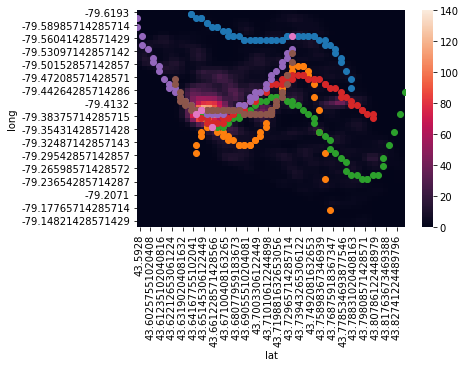

In [49]:
# Draw the System
interchangeCandidatePoints = [(pd.concat(YYZ_Interchange_Candidates)["lat"].to_numpy(), pd.concat(YYZ_Interchange_Candidates)["long"].to_numpy())]
plotHeatmapPolynomial(YYZ_GridPoints, YYZ_Lines + interchangeCandidatePoints, PT_DENSITY)

### Export Cells

In [50]:
with open('coords.txt', 'w') as f:
    f.write("----------LATS-------\n")
    for line in YYZ_Lines:
        f.write("[")
        for lat in line[0]:
            f.write(str(lat))
            f.write(',')
        f.write("],")
        f.write("\n")
    f.write("----------LONGS-------\n")
    for line in YYZ_Lines:
        f.write("[")
        for long in line[1]:
            f.write(str(long))
            f.write(',')
        f.write("],")
        f.write("\n")

# Finding Stations

In [180]:
#line numbers are 0 indexed
YYZ_Cx_Station = []


def stationFinder(threshold, subwayLines, lineNum, YYZ_Cx_Station):
    size = len(subwayLines[lineNum][0])
    df = pd.DataFrame()

    for index in range(0, size):

        lati = subwayLines[lineNum][0][index]
        longi = subwayLines[lineNum][1][index]

        #print(YYZ_C_Scores.index.values)

        scoreIndex = YYZ_GridPoints.loc[(abs(YYZ_GridPoints["lat"] - lati) <= 0.00001) & (
                    abs(YYZ_GridPoints["long"] - longi) <= 0.00001)].index.values
        #print(scoreIndex)

        #check the score at this lat and long
        if len(scoreIndex) > 0:

            scoreInd = scoreIndex[0]
            score = YYZ_GridPoints["score"][scoreIndex]

            #print(score)

            #if above desire threshold add to data frame which we will then convert to numpy array
            if score[scoreIndex][scoreInd] >= threshold:
                #print("Hello")
                if df.empty:
                    d = {'lat': [lati], 'long': [longi]}
                    df = pd.DataFrame(data=d)
                else:

                    new_row = {'lat': lati, 'long': longi}
                    df = df.append(new_row, ignore_index=True)

    #convert data frame to numpy array to append to list so we can plot
    lineStat = (df['lat'].values, df['long'].values)

    YYZ_Cx_Station.append(lineStat)

    #return the new set of points
    return YYZ_Cx_Station

In [181]:
#lineNum is not 0 indexed
def getStation(threshold, lineNum):
    for idx in range(0, lineNum):
        stationFinder(threshold,YYZ_Cx_Line, idx, YYZ_Cx_Station)
    #return YYZ_Cx_Station

In [182]:
getStation(0.9, 5)

KeyError: 'lat'

In [ ]:
plotHeatmapPolynomial(YYZ_GridPoints, YYZ_Cx_Station)